# Regression Models Tuning
---
From our previous modelling and from the literature it is clear that some targets will be easier to predict than others. We will reduce the number of algortihms and the number of features to reduce training times which may also improve performance.

In this notebook we test a reduced feature set which was derived from previous modelling efforts on this task. These features were derived, by one by one, leaving each descriptive feature out of a random forest regression model and measuring the decrease in preformance - denoted as the ErrorDelta. 

Also we will run a randomised search over the reccomended hyperparameters to see how these hyperparameters affect our learning.

At the end of the notebook we will examine our hyperparameter tuning and choose our final modeling techniques for evaluation.

In [100]:
# Math/Data Libraries
import scipy
import numpy as np
import pandas as pd

# Visalisation
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# I/O
import json
import xlrd

# Jupyter/IPython Utility
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Paths

In [149]:
path_to_transformed_data = "../../../data/transformed/"
path_to_data = "../../../data/"
path_to_models = '../models/'
top20features_file = 'dream/winning_team_individual_paper/top20features.xlsx'


In [4]:
# Read Data
df = pd.read_pickle(path_to_transformed_data + 'mean_training_set.zip')

## What we learned from Baseline Modelling

- Some targets are far easier than others to predict. From our baseline modelling and from the literature I have chosen 9 targets from the semantic descriptors as well as intensity and pleasentness. 
- Linear Ridge and Linear (OLS) performed poorly on baseline. With 3700+ descriptive features this is expected.
- ElasticNet & LASSO performing well due to L1 regularization.
- Random forest methods perform modestly - are likely hindered by hyperparameters 
- AdaBoost performs well on Pleasantness & Intensity but not on the semantic decriptors.
- Gradient Tree Boosting looks promising 

In [5]:
X = df.iloc[:, 25:]
X['Odor dilution'] = df['Odor dilution']

In [10]:
# Impute zero where missing values

print('Before dropna() - 1160 columns containing NaN: ')
X.isna().any().value_counts()
X.fillna(0, inplace=True)
print('After dropna() - No columns containing NaN: ')
X.isna().any().value_counts()

Before dropna() - 1160 columns containing NaN: 


False    3710
True     1160
dtype: int64

After dropna() - No columns containing NaN: 


False    4870
dtype: int64

In [11]:
# New targets - Most promising from baseline learners
target_names = ["INTENSITY",
                "PLEASANTNESS",
                "FRUIT",
                "SWEATY",
                "CHEMICAL",
                "GARLIC",
                "SWEET",
                "ACID",
                "FISH",
                "URINOUS",
                "MUSKY",
               ]

Y = df.loc[:, target_names]

## Feature Space Testing
---
One method for determining feature importance is to use random forest decision trees to formulate feature importance values. These values are based on ...

Another moethod which was performed by the winning team of DREAM subchallenge 1 (individual prediction) is Error delta method. This method measures the increase in error rates when a feature is exluded from the descriptive features of a training set. As such the features which produce the biggest change in prediction when removed are subbed to be the most important features for prediction.

The team released the top 20 features for each target. First I will train some baseline models to test the change in training times and performance when using the curated feature set for each target.

In [102]:
top20features = pd.read_excel(path_to_data + top20features_file)

In [12]:
# from sklearn import feature_selection ### try published top 20 for now
# SelectFromModel(LinearSVC(penalty="l1")) ### use to select features as poert of pipeline

# Pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer


# Algorithms - Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

# scikit learn utilities
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, cross_val_predict

In [14]:
# Assemble Pipelines for base learners

linear_ols = make_pipeline(StandardScaler(), LinearRegression())
linear_ridge = make_pipeline(StandardScaler(), Ridge())
linear_lasso = make_pipeline(StandardScaler(), Lasso())
linear_elastic = make_pipeline(StandardScaler(), ElasticNet())
bayesian_ridge_regression = make_pipeline(StandardScaler(), BayesianRidge())

random_forest = make_pipeline(StandardScaler(), RandomForestRegressor())
extra_trees = make_pipeline(StandardScaler(), ExtraTreesRegressor())
ada_boost = make_pipeline(StandardScaler(), AdaBoostRegressor())
gradient_boosting = make_pipeline(StandardScaler(), GradientBoostingRegressor())

neural_net = make_pipeline(StandardScaler(), MLPRegressor())

In [15]:
BASE_LEARNER_TITLES = ['Linear (OLS)',
                       'Linear (Ridge)',
                       'Linear (Lasso)',
                       'Linear (ElasticNet)',
                       'Linear (BayesianRidge)',
                       'Random Forest',
                       'ET Random Forest',
                       'AdaBoost',
                       'Gradient Boosting',
                       'Neural Net',
                      ]

In [16]:
# create dataframe for prediction results
cross_val_predictions = pd.DataFrame(data=Y.values,
                                    columns=[t + ' (ACTUAL)' for t in target_names])

In [17]:
%%time
# 5-Fold Cross validation - for each target in Y
for target in target_names:
    feature_names = list(top20features[target])
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[0]) +')'] = cross_val_predict(linear_ols, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[1]) +')'] = cross_val_predict(linear_ridge, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[2]) +')'] = cross_val_predict(linear_lasso, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[3]) +')'] = cross_val_predict(linear_elastic, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[4]) +')'] = cross_val_predict(bayesian_ridge_regression, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[5]) +')'] = cross_val_predict(random_forest, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[6]) +')'] = cross_val_predict(extra_trees, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[7]) +')'] = cross_val_predict(ada_boost, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[8]) +')'] = cross_val_predict(gradient_boosting, X[feature_names], Y[target], cv=5)
    cross_val_predictions[(target +' ('+ BASE_LEARNER_TITLES[9]) +')'] = cross_val_predict(neural_net, X[feature_names], Y[target], cv=5)

# produces convergence warnings for most of the neural network instances

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multila

CPU times: user 1min 47s, sys: 6.81 s, total: 1min 54s
Wall time: 1min 54s


/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Intensity Predictions

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - INTENSITY')

INTENSITY (Linear (OLS))              0.172833
INTENSITY (Linear (Ridge))            0.171911
INTENSITY (Linear (Lasso))            0.048377
INTENSITY (Linear (ElasticNet))       0.078910
INTENSITY (Linear (BayesianRidge))    0.123804
INTENSITY (Random Forest)             0.181056
INTENSITY (ET Random Forest)          0.204457
INTENSITY (AdaBoost)                  0.205806
INTENSITY (Gradient Boosting)         0.224549
INTENSITY (Neural Net)                0.055578
Name: actual, dtype: float64

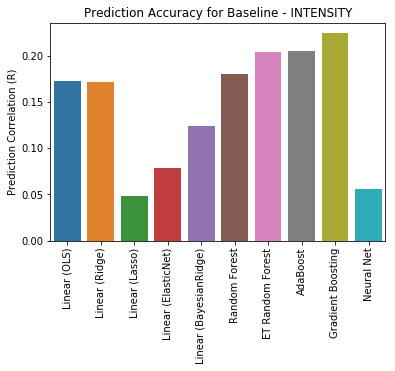

In [29]:
int_predictions = cross_val_predictions.iloc[:, 11:21]
int_predictions['actual'] = cross_val_predictions.iloc[:, 0]
int_predictions_corr = int_predictions.corr()['actual'][:-1]
sb.barplot(x=BASE_LEARNER_TITLES, y=int_predictions_corr.values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - INTENSITY')
int_predictions_corr

### Intensity Results
Pedictions are worse overall compared to using all features

## Pleasantness Predictions

Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - PLEASANTNESS')

PLEASANTNESS (Linear (OLS))             -0.039766
PLEASANTNESS (Linear (Ridge))            0.346492
PLEASANTNESS (Linear (Lasso))            0.387748
PLEASANTNESS (Linear (ElasticNet))       0.398009
PLEASANTNESS (Linear (BayesianRidge))    0.397571
PLEASANTNESS (Random Forest)             0.518581
PLEASANTNESS (ET Random Forest)          0.487552
PLEASANTNESS (AdaBoost)                  0.495528
PLEASANTNESS (Gradient Boosting)         0.502226
PLEASANTNESS (Neural Net)                0.257037
Name: actual, dtype: float64

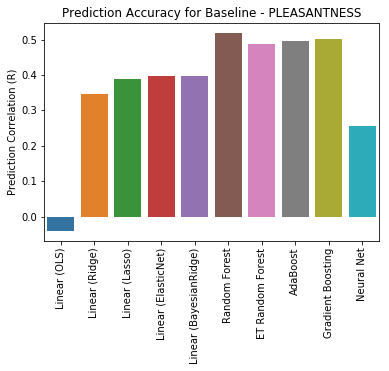

In [30]:
ple_predictions = cross_val_predictions.iloc[:, 21:31]
ple_predictions['actual'] = cross_val_predictions.iloc[:, 1]
ple_predictions_corr = ple_predictions.corr()['actual'][:-1]
sb.barplot(x=BASE_LEARNER_TITLES, y=ple_predictions_corr.values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - PLEASANTNESS')
ple_predictions_corr

### Peasentness Results

These results are similar or worse than our base learners using all features. Random forrest by contrast displays an increase in prediction accuracy - obviously due to the fact that this is the algorithm from which these features were derived. 

## Semantic Predictions

In [34]:
sem_predictions = cross_val_predictions.iloc[:, 31:]
semantic_labels = target_names[2:]
for label, i in zip(semantic_labels, range(len(sem_predictions))):
    sem_predictions[label] = cross_val_predictions.iloc[:, (i+2)]

In [38]:
sem_predictions_corr = pd.DataFrame()
for i in range(0, 90, 10):
    sem_predictions_corr[semantic_labels[i//10]] = sem_predictions.corr()[semantic_labels[i//10]][i:i+10].values


sem_predictions_corr['Algorithm'] = BASE_LEARNER_TITLES

sem_predictions_corr.set_index('Algorithm', inplace=True)

In [42]:
sem_predictions_corr

,FRUIT,SWEATY,CHEMICAL,GARLIC,SWEET,ACID,FISH,URINOUS,MUSKY
Algorithm,,,,,,,,,
Linear (OLS),0.310805,0.144619,0.170654,0.058976,0.101722,0.073598,-0.001942,0.154701,0.201716
Linear (Ridge),0.310491,0.145953,0.162422,0.125047,0.103581,0.076613,0.184359,0.154987,0.202007
Linear (Lasso),0.259432,0.083288,0.192308,0.003073,0.114760,-0.077472,0.142247,0.135676,0.185030
Linear (ElasticNet),0.284183,0.123798,0.198408,0.034908,0.142235,-0.021975,0.183881,0.146344,0.211807
Linear (BayesianRidge),0.305991,0.133395,0.171211,0.027730,0.161378,0.019343,0.198043,0.150909,0.222053
Random Forest,0.218005,0.120342,0.052286,0.115785,0.199929,-0.011826,0.163223,0.096131,0.183247
ET Random Forest,0.261089,0.142280,0.102871,0.117071,0.197139,0.023485,0.148635,0.163489,0.180694
AdaBoost,0.212645,0.149688,0.099683,0.122419,0.083556,0.112711,0.119079,0.130744,0.201426
Gradient Boosting,0.284507,0.186088,0.056633,0.121035,0.220037,0.044162,0.162580,0.181500,0.177426


Text(0,0.5,'Prediction Correlation (R)')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5,1,'Prediction Accuracy for Baseline - Average of Semantic Descriptors')

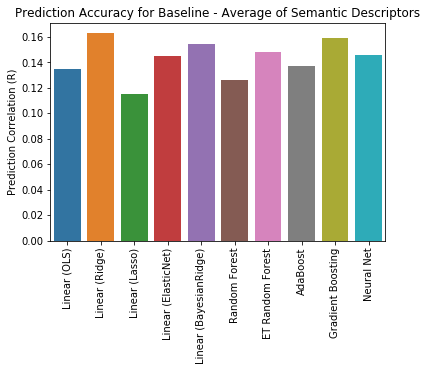

In [40]:
sb.barplot(x=BASE_LEARNER_TITLES, y=sem_predictions_corr.mean(axis=1).values).set_ylabel('Prediction Correlation (R)')
plt.xticks(rotation=90)
plt.title('Prediction Accuracy for Baseline - Average of Semantic Descriptors')

### Results from feature reduction
---
Using the top 20 features published previously we have reduced our training time vastly and our predictions have improved in some cases and degraded in others. 

Linear Least Squares and Linear Ridge algorithms now perform more comparably to the others as expected.

I expected a greater increase in our accuracy from random forest methods but I believe that these methods are still hindered by defalut parameters and the ill-posed nature of training using the mean responses. My own previous experiments have shown that random forest methods perform poorly until n_trees is increased beyond the default. 

The correlation from predictions on pleasantness vs target pleasentness values jumped from 0.43 to 0.51 for Random Forest when using 20 features vs all features.

## Reset Data

In [43]:
X = df.iloc[:, 25:]
X['Odor dilution'] = df['Odor dilution']

print('Before dropna() - 1160 columns containing NaN: ')
X.isna().any().value_counts()
X.dropna(how='any', axis=1, inplace=True)
print('After dropna() - No columns containing NaN: ')
X.isna().any().value_counts()

Y = df.loc[:, target_names]

Before dropna() - 1160 columns containing NaN: 


False    3710
True     1160
dtype: int64

After dropna() - No columns containing NaN: 


False    3710
dtype: int64

## Hyperparameter Tuning - Randomised Search
---

- Here our goal is to improve our model predictions using a Randomized Search Grid cross validation process.

- We sample different parameter values `n` times and perform `k`-fold cross validation `n*k` times using `n` different random parameters from a distribution we select. 

- Ideally we want to find models of different types that predict well so we can perform XAI techniques on said models and compare the interpretation process accross machine learning algortihms.

- As such, our goal is not to train the best model possible but rather train a variety that are good enough. 

- Then we will test these tuned models on our test data (to guage their real world predictiveness) and persist the best performing models.

In [167]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform

# lists to store our results & tune parameters
params = []
pipelines = []
grids = {}

# add ML pipelines to list
pipelines.append(linear_lasso)
pipelines.append(linear_elastic)
pipelines.append(random_forest)
pipelines.append(extra_trees)
pipelines.append(gradient_boosting)

# specify parameters and distributions to sample from
params.append({'lasso__alpha': uniform(0.001, 1)})
params.append({'elasticnet__alpha': uniform(0.001, 1),
               'elasticnet__l1_ratio': uniform(0, 1)})
params.append({'randomforestregressor__n_estimators': [10, 20, 50, 100, 1000],
               'randomforestregressor__max_depth': [None, 5, 10]})
params.append({'extratreesregressor__n_estimators': [10, 50, 100, 200, 2000],
               'extratreesregressor__max_depth': [None, 5, 10]})
params.append({'gradientboostingregressor__n_estimators': [100, 200, 300, 2000],
               'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.15],
               'gradientboostingregressor__subsample': [0.8, 1]})


In [168]:
%%time # 18 HOURS!
# run randomized search
n_iter_search = 12

for i in range(5):
    # 5 Algorithms 
    for target in target_names:
        # 11 targets
        model_grid = RandomizedSearchCV(pipelines[i], param_distributions=params[i],
                                    n_iter=n_iter_search, cv=3, scoring='r2',
                                    return_train_score=False)
        model_grid.fit(X, Y[target])
        grids[target + ' ' + i.__str__()] = model_grid

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealyd2/envs/py3training/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/admin/workspace/2018-mcm-kealy

CPU times: user 17h 59min 14s, sys: 5min 11s, total: 18h 4min 25s
Wall time: 18h 16min 7s


In [196]:
maxScore = 0
for k, v in grids.items():
    if v.best_score_ > maxScore:
        maxScore = v.best_score_

# r^2 scoring method
maxScore

0.03951333329083488

Best Pearson correlation of 0.19877 between predicted values and actual. This reduced performance was unexpected but can be explained by a number of factors. Earlier cross validation scores were calculated using 5-fold and this was set to 3 fold for to ease computational expense.

In essence these models only had access to 2/3 of the data whereas the baseline models had access to 4/5 of the data (66% vs 80% of training set).

Aditionally by varying many hyperparameters at once using RandomizedSearchGrid is highly stochastic in nature. I was hoping for better results but we can use these results combined with the literature to pick some final hyperparameters and train our final models.

## Final Training
---
Regularised Linear models and Random Forest methods perform best and to reduce the training time and scope of the investigation I will limit final modelling to these two methods. The reason this limitation is that regularised linear models perform best with the addition of squared feature values - making the fit quadratic. This increases our feature space to nearly 10,000 descriptive features and make slows training. 

On the other hand the random forest methods only seem to work well with a large number of trees due to the inherant noise in the data. Increasing the number of trees in the forest makes traiing again more expensive. 

These methods have performed best in my own experiments and in the literature, so this is my final effort to train models as predictive as the winners of the DREAM challenge.

In [5]:
X = df.iloc[:, 25:]
X['Odor dilution'] = df['Odor dilution']

# New targets - Most promising from literature - 8 targets
target_names = ["INTENSITY",
                "PLEASANTNESS",
                "FRUIT",
                "GARLIC",
                "SWEET",
                "FISH",
                "SPICES", 
                "BURNT"
               ]


Y = df.loc[:, target_names]

## Regularised Linear Model

In [98]:
linear_models = {}

for target in target_names:
    cbrt_ss_lasso = make_pipeline(Imputer(strategy='median'), FunctionTransformer(np.cbrt),
                                  StandardScaler(), Lasso())
    linear_models[target] = cbrt_ss_lasso.fit(X, Y[target])


## Random Forest Model

In [129]:
%%time
rf_models = {}

# cube root transform => standard scalar
for target in target_names:
    cbrt_ss_rf = make_pipeline(Imputer(strategy='median'), FunctionTransformer(np.cbrt),
                               StandardScaler(), RandomForestRegressor(n_estimators=1000, random_state=42))
    rf_models_all[target] = cbrt_ss_rf.fit(X, Y[target])

CPU times: user 2h 22min 49s, sys: 20.6 s, total: 2h 23min 10s
Wall time: 2h 24min 22s


#### Testing different data transformations

In [118]:
%%time
rf_models = {}

# standard scaler - no cuberoot transform
for target in target_names:
    cbrt_ss_rf = make_pipeline(Imputer(strategy='median'), StandardScaler(),
                               RandomForestRegressor(n_estimators=1000, random_state=42))
    rf_models_all_features[target] = cbrt_ss_rf.fit(X[top20features[target]], Y[target])

CPU times: user 1min 9s, sys: 1.17 s, total: 1min 10s
Wall time: 1min 11s


In [121]:
%%time
rf_models = {}

# Robust Scalar
for target in target_names:
    cbrt_ss_rf = make_pipeline(Imputer(strategy='median'), RobustScaler(),
                               RandomForestRegressor(n_estimators=1000, random_state=42))
    rf_models_20_features[target] = cbrt_ss_rf.fit(X[top20features[target]], Y[target])

CPU times: user 1min 10s, sys: 640 ms, total: 1min 10s
Wall time: 1min 11s


## Testing on Test Set
--- 
- Test the models using the best hyperparameters obtained through Randomized Grid Search.
- Test on the hidden test set to guage their real world performance.
- Take the top performing models on test set and persist them for investigation.

### Transform hidden test set to match training data

In [155]:
test_set = pd.read_pickle(path_to_transformed_data + 'mean_test_set.zip')
Y_test = test_set[target_names]

X_test = test_set.iloc[:, 25:] 
X_labels = list(test_set.iloc[:, 25:].columns)
X_test['Odor dilution'] = test_set['Odor dilution']
X_labels.append('Odor diltution')

In [59]:
impute = Imputer(strategy='median')
X_test = pd.DataFrame(data=impute.fit_transform(X_test), columns=X_labels)
X_test.isna().any().value_counts()

False    4870
dtype: int64

In [60]:
X_test = X_test.apply(np.cbrt)

In [61]:
ss = StandardScaler()
X_test = pd.DataFrame(data=ss.fit_transform(X_test), columns=X_labels)

## Linear Modelling Results



In [160]:
linear_predictions = pd.DataFrame()

for target in target_names:
    linear_predictions[target + '(ACTUAL)'] = Y_test[target]
    linear_predictions[target] = linear_models[target].predict(X_test)

In [161]:
print('Correlation between predicted and actual - Hidden Test Set\n')
for target in target_names:
    print(target + ':\t\t' +linear_predictions.corr()[target].loc[target + '(ACTUAL)'].__str__())

Correlation between predicted and actual - Hidden Test Set

INTENSITY:		0.7111599511196067
PLEASANTNESS:		0.5893705097721007
FRUIT:		0.3436008370958339
GARLIC:		0.19432967013996613
SWEET:		0.30047444262631223
FISH:		0.21493717416304634
SPICES:		-0.08308744181403223
BURNT:		0.16394026249943813


## Random Forest Results
---
Sweet & Fish are predicted well by 


These results are comparable than our baseline learner which is odd because this preprocessing was inspired by the top team who also used sklearn `RandomForrestRegressor()`. Although there are contradictions, inconsistencies and some ommissions in the winning teams write up so it is impossible to tell if we completely used the same methodology.

A direct comparrison is not fair because we scored our base learners through cross validation on the training set and these learners on a hidden test set.





In [156]:
rf_predictions = pd.DataFrame()

for target in target_names:
    rf_predictions[target + '(ACTUAL)'] = Y_test[target]
    rf_predictions[target] = rf_models_20_features[target].predict(X_test)

In [157]:
print('Correlation between predicted and actual - Hidden Test Set\n20 Features:\n')
for target in target_names:
    print(target + ':\t\t' +rf_predictions.corr()[target].loc[target + '(ACTUAL)'].__str__())

Correlation between predicted and actual - Hidden Test Set
20 Features:

INTENSITY:		0.6800345687852398
PLEASANTNESS:		0.6277735944144781
FRUIT:		0.2257141541077509
GARLIC:		0.16667352128249757
SWEET:		0.33472689929336186
FISH:		0.22460197540789578
SPICES:		0.08803537296501845
BURNT:		0.12960620729646305


In [158]:
for target in target_names:
    rf_predictions[target + '(ACTUAL)'] = Y_test[target]
    rf_predictions[target] = rf_models_all_features[target].predict(X_test)

In [159]:
print('Correlation between predicted and actual - Hidden Test Set\nAll Features:\n')
for target in target_names:
    print(target + ':\t\t' +rf_predictions.corr()[target].loc[target + '(ACTUAL)'].__str__())

Correlation between predicted and actual - Hidden Test Set
All Features:

INTENSITY:		0.7397777098109073
PLEASANTNESS:		0.6446791896319177
FRUIT:		0.294602514776483
GARLIC:		0.24522356569282383
SWEET:		0.3426858644523011
FISH:		0.2801446533955109
SPICES:		0.004239158120352043
BURNT:		0.1618787869153477


# Persist Fitted Models for interpretation

In [162]:
from sklearn.externals import joblib


for target in target_names:
    file = 'rf_' + target + '_all.pkl'
    joblib.dump(rf_models_all_features[target], path_to_models + file) 

['../models/rf_INTENSITY_all.pkl']

['../models/rf_PLEASANTNESS_all.pkl']

['../models/rf_FRUIT_all.pkl']

['../models/rf_GARLIC_all.pkl']

['../models/rf_SWEET_all.pkl']

['../models/rf_FISH_all.pkl']

['../models/rf_SPICES_all.pkl']

['../models/rf_BURNT_all.pkl']

In [153]:
for target in target_names:
    file = 'rf_' + target + '_20.pkl'
    joblib.dump(rf_models_20_features[target], path_to_models + file) 

['../models/rf_INTENSITY_20.pkl']

['../models/rf_PLEASANTNESS_20.pkl']

['../models/rf_FRUIT_20.pkl']

['../models/rf_GARLIC_20.pkl']

['../models/rf_SWEET_20.pkl']

['../models/rf_FISH_20.pkl']

['../models/rf_SPICES_20.pkl']

['../models/rf_BURNT_20.pkl']

In [154]:
for target in target_names:
    file = 'lasso_' + target + '_all.pkl'
    joblib.dump(linear_models[target], path_to_models + file) 

['../models/lasso_INTENSITY_all.pkl']

['../models/lasso_PLEASANTNESS_all.pkl']

['../models/lasso_FRUIT_all.pkl']

['../models/lasso_GARLIC_all.pkl']

['../models/lasso_SWEET_all.pkl']

['../models/lasso_FISH_all.pkl']

['../models/lasso_SPICES_all.pkl']

['../models/lasso_BURNT_all.pkl']